# Multiple Importance Sampling

Working off of [this resource](https://graphics.stanford.edu/courses/cs348b-03/papers/veach-chapter9.pdf).

Let our test function $f_{a, b}$ be:

$$ f_{a, b}(x) = a e^{-(2 + x)^2} + b e^{-(2 - x)^2} $$

For some given fixed $a$ and $b$ our goal will be to numerically evaluate:

$$ \int_{\mathbb{R}} f_{a, b}(x) \, \mathrm{d}x = (a + b) \sqrt{\pi} $$

We will do this first via [Importance Sampling](https://en.wikipedia.org/wiki/Importance_sampling) with three candidate distributions: Normal centered around -2, normal centered around +2, and normal centered around 0.

Finally, we will use the balance heuristic with Multiple Importance Sampling, and show that this yields better performance across a range of choices of $a$ and $b$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random, math, collections

In [2]:
def f(a, b):
    # Curry the third argument.
    return lambda x: a * math.exp(-(2 + x)**2) + b * math.exp(-(2 - x)**2)

def plot(f, low, high, num=100):
    xs = np.linspace(low, high, num=num)
    plt.plot(xs, map(f, xs))

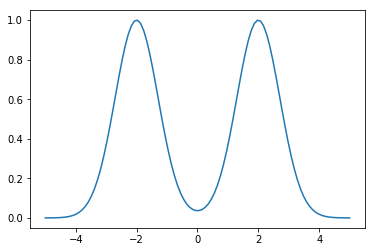

In [3]:
plot(f(1, 1), -5, 5)

In [4]:
def importance_sample(f, generate, pdf, N):
    total = 0.0
    for _ in xrange(N):
        x = generate()
        total += f(x) / pdf(x)
    return total / N

In [5]:
def generate_normal(mean, variance):
    return lambda: random.normalvariate(mean, variance**0.5)

def pdf_normal(mean, variance):
    return lambda x: math.exp(-(x - mean)**2 / (2 * variance)) / math.sqrt(2 * math.pi * variance)

result = importance_sample(f(1, 1), generate_normal(1, 3), pdf_normal(1, 3), 10000)
print result
print "Target result:", 2 * math.sqrt(math.pi)

3.54703578398
Target result: 3.54490770181


In [6]:
def estimator_variance(true_value, estimator, N):
    errors = np.array([estimator() for _ in xrange(N)]) - true_value
    # No Bessel correction needed to be unbiased, as the true value is known.
    return np.mean(errors**2)

In [7]:
parameter_range = [(0, 3), (0, 5), (1, 3), (1, 5)]
for parameters in parameter_range:
    estimator_var = estimator_variance(
        true_value = 2 * math.sqrt(math.pi),
        estimator = lambda: importance_sample(
            f(1, 1),
            generate_normal(*parameters),
            pdf_normal(*parameters),
            100,
        ),
        N = 10000,
    )
    print "Using importance sampling distribution with mean = %s and variance = %s yields variance: %s" % (
        parameters[0],
        parameters[1],
        estimator_var,
    )

Using importance sampling distribution with mean = 0 and variance = 3 yields variance: 0.110336785407
Using importance sampling distribution with mean = 0 and variance = 5 yields variance: 0.097431245552
Using importance sampling distribution with mean = 1 and variance = 3 yields variance: 0.234892908172
Using importance sampling distribution with mean = 1 and variance = 5 yields variance: 0.143700052756


## Now let's use MIS

In [8]:
def balance_heuristic_mis(f, samples_each, generators, pdfs):
    N = sum(samples_each)
    total = 0.0
    for samples, generator, pdf in zip(samples_each, generators, pdfs):
        for _ in xrange(samples):
            x = generator()
            p = sum((s / float(N)) * sub_pdf(x) for s, sub_pdf in zip(samples_each, pdfs))
            total += f(x) / p
    return total / N
        

In [9]:
test = lambda: balance_heuristic_mis(
    f(1, 1),
    [50, 50],
    [
        generate_normal(1, 3),
        generate_normal(-1, 3),
    ],
    [
        pdf_normal(1, 3),
        pdf_normal(-1, 3),
    ],
)
print estimator_variance(
    true_value = 2 * math.sqrt(math.pi),
    estimator = test,
    N = 10000,
)

0.0903493934695


# Using MIS for rendering

We will now define a simple rendering pipeline, and attempt to reproduce the diagram of figure 9.2 from the linked notes.

In [10]:
def normalized(x):
    return np.array(x, dtype=np.float64) / np.linalg.norm(x)

def scatter(roughness, v):
    if roughness is None:
        return None
    displace = normalized(np.random.randn(3))
    return normalized(displace * roughness + normalized(v))

class Ray:
    def __init__(self, origin, direction):
        self.origin = np.array(origin, dtype=np.float64)
        self.direction = normalized(direction)

Hit = collections.namedtuple("Hit", ["distance", "point", "reflection", "energy"])
no_hit = Hit(float("inf"), None, None, 0.0)

class Sphere:
    def __init__(self, center, radius, emission, roughness):
        self.center = center
        self.radius = radius
        self.emission = emission
        self.roughness = roughness

    def cast_ray(self, ray):
        offset = self.center - ray.origin
        base_d = ray.direction.dot(offset)
        discriminant = base_d**2 - np.linalg.norm(offset)**2 + self.radius**2
        if discriminant < 0:
            return no_hit
        root = math.sqrt(discriminant)
        if base_d - root < 0:
            return no_hit
        hit_point = ray.origin + ray.direction * (base_d - root - 1e-2)
        normal = normalized(hit_point - self.center)
        reflection = ray.direction - (2 * normal.dot(ray.direction)) * normal
        reflection = scatter(self.roughness, reflection)
        return Hit(base_d - root, hit_point, reflection, self.emission)

class Plane:
    def __init__(self, normal, point_on_plane, emission, roughness):
        self.normal = normalized(normal)
        self.height = np.dot(normal, point_on_plane)
        self.emission = emission
        self.roughness = roughness

    def cast_ray(self, ray):
        origin_height = self.normal.dot(ray.origin) - self.height
        if origin_height < 0:
            return no_hit
        rate = -self.normal.dot(ray.direction)
        if rate <= 0:
            return no_hit
        approach_distance = origin_height / rate
        hit_point = ray.origin + ray.direction * approach_distance
        reflection = ray.direction - (2 * self.normal.dot(ray.direction)) * self.normal
        reflection = scatter(self.roughness, reflection)
        return Hit(approach_distance, hit_point, reflection, self.emission)

class PlaneSegment(Plane):
    def __init__(self, normal, point_on_plane, x_bounds, y_bounds, emission, roughness):
        Plane.__init__(self, normal, point_on_plane, emission, roughness)
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

    def cast_ray(self, ray):
        hit = Plane.cast_ray(self, ray)
        if hit.point is not None and \
                self.x_bounds[0] < hit.point[0] < self.x_bounds[1] and \
                self.y_bounds[0] < hit.point[1] < self.y_bounds[1]:
            return hit
        return no_hit

class LightSamplingPlaneSegment(PlaneSegment):
    def __init__(self, normal, point_on_plane, x_bounds, y_bounds, emission, roughness, lights):
        PlaneSegment.__init__(self, normal, point_on_plane, x_bounds, y_bounds, emission, roughness)
        assert all(isinstance(light, Sphere) for light in lights)
        self.lights = lights

    def cast_ray(self, ray):
        # Pick a random light.
        light = random.sample(self.lights)
        # Pick a random ray towards on the light.
        pass

class Scene:
    def __init__(self, objects):
        self.objects = objects

    def cast_ray(self, ray):
        best_hit = no_hit
        for obj in self.objects:
            new_hit = obj.cast_ray(ray)
            if new_hit.distance < best_hit.distance:
                best_hit = new_hit
        return best_hit

def path_trace(scene, ray, bounces=1):
    energy = 0.0
    hit = scene.cast_ray(ray)
    if hit.point is not None:
        energy += hit.energy #/ hit.distance**2.0
        if bounces > 0 and hit.reflection is not None:
            # Scatter the direction.
            #reflection = scatter(hit.roughness, hit.reflection)
            # We back the hit off of the surface a tiny bit so we don't hit it again on the way out.
            origin = hit.point + hit.reflection * 0.001
            reflection_ray = Ray(origin, hit.reflection)
            energy += path_trace(scene, reflection_ray, bounces=bounces-1)
    return energy

def mcpt(scene, size, samples):
    width, height = size
    result = np.zeros([width, height])
    for _ in xrange(samples):
        for y in xrange(height):
            for x in xrange(width):
                camera_direction = [1, x / float(width) - 0.5, 0.5 - y / float(height)]
                camera_ray = Ray([0, 0, 0], camera_direction)
                # Because it is standard to have matrices to index by (row, column), we swap y and x here:
                result[y, x] += path_trace(scene, camera_ray)
    return result / samples

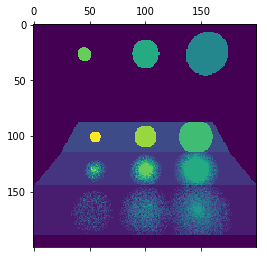

In [11]:
scene = Scene([
    #Sphere([-2, 0, 0], 2, 1.0, 0.0),
    #Sphere([3, 0, 0], 0.5, 0.1, 1.0),
    #Sphere([3, 1, 0.5], 1.5, 0.1, 1.0),
    #Plane([0, 0, 1], [0, 0, -1], 0.1, 1.0),
    #Sphere([5.5, -1.5, 2], 0.5 * (1/3.0), (3/1.0)**2, None),
    #Sphere([5.5, 0, 2], 0.5 * (2/3.0), (3/2.0)**2, None),
    #Sphere([5.5, 1.5, 2], 0.5, 1.0, None),
    Sphere([5.5, -1.5, 2], 0.5 * (1/3.0), 5, None),
    Sphere([5.5, 0, 2], 0.5 * (2/3.0), 4, None),
    Sphere([5.5, 1.5, 2], 0.5, 3, None),
    PlaneSegment([-0.21, 0, 1], [2.5, 0, -0.75], (2, 3), (-1.5, 1.5), 0.5, 0.1),
    PlaneSegment([-0.38, 0, 1], [3.5, 0, -0.37], (3, 4), (-1.5, 1.5), 1.0, 0.05),
    PlaneSegment([-0.6, 0, 1], [4.5, 0, +0.4], (4, 5), (-1.5, 1.5), 1.5, 0.0),
])
image = mcpt(scene, (200, 200), 10)
_ = plt.matshow(image)